In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_model_optimization as tfmot
import tensorflow as tf
import os
import tempfile
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [2]:
dataset = pd.read_excel('train_3rd_wrv.xlsx').values

In [51]:
past_hours = 1
n_steps = past_hours
next_hours = 1
next_steps = next_hours

In [80]:
train_percentage = 80
val_percentage = 20
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    index = [i for i in range (len(dataset))]
    np.random.shuffle(index)
    dataset_random = dataset[index,:]
    return dataset_random[:int(data_size*percentage/100)],dataset_random[int(data_size*percentage/100):]

train_dataset,val_dataset = slice_dataset(dataset, train_percentage)

In [127]:
x_train = np.expand_dims(train_dataset[:,0:5200].astype(float),axis =2)
Y_train = np.expand_dims(train_dataset[:,7000].astype(float),axis =1)
x_test = np.expand_dims(val_dataset[:,0:5200].astype(float),axis =2)
Y_test = np.expand_dims(val_dataset[:,7000].astype(float),axis =1)

In [128]:
Y_test

array([[4.5],
       [5.5],
       [5.5],
       [3. ],
       [4. ],
       [3. ],
       [4. ],
       [6.5],
       [4.5],
       [7.5],
       [6.5],
       [7. ],
       [3.5],
       [7.5],
       [6.5],
       [5.5],
       [4. ],
       [4. ],
       [4. ],
       [7.5],
       [4.5],
       [6. ],
       [7. ],
       [8. ],
       [3. ],
       [6.5],
       [3.5],
       [8. ],
       [8. ],
       [5. ],
       [8. ],
       [4.5],
       [7.5],
       [3.5],
       [3. ],
       [4.5],
       [6.5],
       [6.5],
       [6.5],
       [5.5],
       [7.5],
       [5.5],
       [4. ],
       [4.5],
       [7. ],
       [5.5],
       [4.5],
       [3. ],
       [4. ],
       [7. ],
       [6.5],
       [5. ],
       [6.5],
       [6.5],
       [5. ],
       [4.5],
       [8. ],
       [7. ],
       [7. ],
       [3.5],
       [8. ],
       [7. ],
       [7. ],
       [3. ],
       [8. ],
       [4.5],
       [5. ],
       [7. ],
       [4.5],
       [4. ],
       [7.5],
      

In [129]:
X_train = x_train.reshape(x_train.shape[0],1, x_train.shape[1])
X_test = x_test.reshape(x_test.shape[0],1, x_test.shape[1])

In [136]:
def setup_model():
    model = keras.Sequential([
        #keras.layers.InputLayer(input_shape =(X_train.shape[1],X_train.shape[2])),
        keras.layers.Conv1D(filters=48, kernel_size=1,strides=1, padding="valid",activation='relu',input_shape =(X_train.shape[1],X_train.shape[2])),
        keras.layers.Conv1D(filters=48, kernel_size=1,strides=1, padding="valid",activation='relu'),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Flatten(),
        #eras.layers.Reshape(target_shape=(99,1,1)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.01),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(next_steps, activation='linear'),
    ])
    return model

In [137]:
base_model = setup_model()
base_model.compile(optimizer = 'adam',
                 loss = 'mse',
                 metrics = ['mae','mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=20, mode='auto')
log_filepath = os.path.join('log')
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_filepath,histogram_freq=1)
history = base_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200,batch_size=16,callbacks=[reduce_lr])
scores = base_model.evaluate(X_test, Y_test, verbose=0)
#model.save(os.path.join(log_filepath,'DNN_model.h5'))
print('%s: %.2f%%' % (base_model.metrics_names[1], scores[1] * 100))

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_43. Consider increasing the input size. Received input shape [None, 1, 5200] which would produce output shape with a zero or negative value in a dimension.

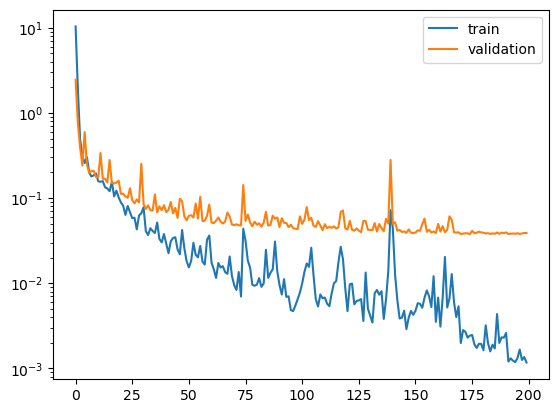

In [132]:
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.yscale('log')
pyplot.legend()
pyplot.show()

In [133]:
predicted =base_model.predict(X_test)
#inverse_data1 = min_max_scaler.inverse_transform(predicted)
#inverse_data2 = min_max_scaler.inverse_transform(Y_test)
print(predicted[1])
print(Y_test[1].reshape(1))
ERR = []
for i in range(0,len(Y_val)):
    error=(predicted[i]-Y_test[i].reshape(1))
    ERR.append(error)
ERR=np.abs(np.array(ERR))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 0s 3ms/step
[5.528168]
[5.5]


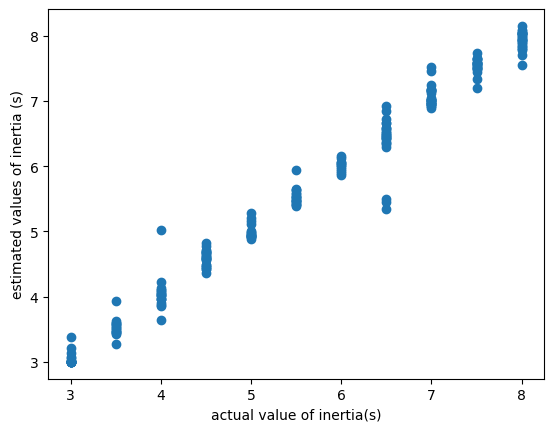

In [134]:
plt.xlabel('actual value of inertia(s)')
plt.ylabel('estimated values of inertia (s)')
plt.scatter(Y_test,predicted)
plt.savefig('Scatters_LRCN_Delay_0.0.png',dpi=1000)
plt.show()

In [135]:
#print(ERR)
absvalues  = ERR.reshape(-1)
def acc(thre):
    Accuracy = np.sum(absvalues<=thre)/len(absvalues)
    return  Accuracy
print('\nTolerance=0.1: Accuracy=',  acc(0.1),
      '\nTolerance=0.2: Accuracy=',  acc(0.2),
      '\nTolerance=0.3: Accuracy=',  acc(0.3),
    '\nTolerance=0.4: Accuracy=', acc(0.4),'\nTolerance=0.5: Accuracy=',  acc(0.5))


Tolerance=0.1: Accuracy= 0.6545454545454545 
Tolerance=0.2: Accuracy= 0.8909090909090909 
Tolerance=0.3: Accuracy= 0.9272727272727272 
Tolerance=0.4: Accuracy= 0.9636363636363636 
Tolerance=0.5: Accuracy= 0.9636363636363636
